<a href="https://colab.research.google.com/github/EmanoneL/data_analysis_pet_project/blob/main/desk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Импорт библиотек

In [14]:
import pandas as pd # Для работы с DataFrame
import numpy as np # Для математических операций с DataFrame
import matplotlib.pyplot as plt # Для работы с графиками и гистограммами
import scipy.stats as stats # Некоторые функции для работы со статистикой
import seaborn as sns # Для ящика с усами
from scipy.stats import kstest # Критерий Колмогорова-Смирнова
from scipy.stats import chi2_contingency # Критерий хи-квадрат

### Пользовательские функции

In [15]:
# Формирует новый столбец(фичу) в DataFrame по данным из столбца price_doc
def price_doc_to_class(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X['class'] = ''

    X.loc[(y <= 3000000), 'class'] = 'cheap'
    X.loc[(y > 3000000) & (y <= 11000000), 'class'] = 'normal'
    X.loc[y > 11000000, 'class'] = 'expensive'

    X = pd.concat([X, y], axis=1)
    return X

In [16]:
# Проверяет близость к нормальному распределению для фичи по критерию Колмогорова-Смирнова
def checkStandart(df, feature_name):
  data = (df[feature_name] - df[feature_name].mean()) / df[feature_name].std()

  # Выполняем K-S тест для проверки нормальности
  stat, p_value = kstest(data, 'norm')
  print(f'Statistic: {stat}, p-value: {p_value}')

  # Интерпретация результата
  alpha = 0.05
  if p_value > alpha:
      print('Распределение близко к нормальному (не отклоняем H0)')
  else:
      print('Распределение отличается от нормального (отклоняем H0)')

In [17]:
def breushPaganTest(X, y):
  X_const = sm.add_constant(X)
  model_sm = sm.OLS(y, X_const).fit()
  test_stat, p_value, _, _ = het_breuschpagan(model_sm.resid, model_sm.model.exog)

  print(f'Test Statistic: {test_stat}')
  print(f'p-value: {p_value}')

  if p_value < 0.05:
      print("Отвергаем нулевую гипотезу: наличие гетероскедастичности.")
  else:
      print("Не отвергаем нулевую гипотезу: гомоскедастичность сохраняется.")

### Загрузка данных

In [18]:
df = pd.read_csv('dataset.csv', index_col=0) # Загружаем файл в DataFrame
df.head(10) # Выводим первые 10 результатов

,full_sq,build_type,price_doc
0,43,modern,5533460.0
1,66,brezh,9900000.0
2,55,brezh,1990000.0
3,45,hrush,6500000.0
4,43,hrush,8500000.0
5,91,modern,15500000.0
6,28,brezh,2544340.0
7,38,brezh,2000000.0
8,31,brezh,990000.0
9,44,brezh,8600000.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5048 entries, 0 to 5047
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full_sq     5048 non-null   int64  
 1   build_type  5048 non-null   object 
 2   price_doc   5047 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 157.8+ KB


Заметим сразу, что в выборке нет пропусков

**Описание датасета**

* **full_sq** - общая площадь
* **build_year** - год постройки
* **price_doc** - цена квартиры

#Дескриптивный анализ

array([[<Axes: title={'center': 'full_sq'}>,
        <Axes: title={'center': 'price_doc'}>]], dtype=object)

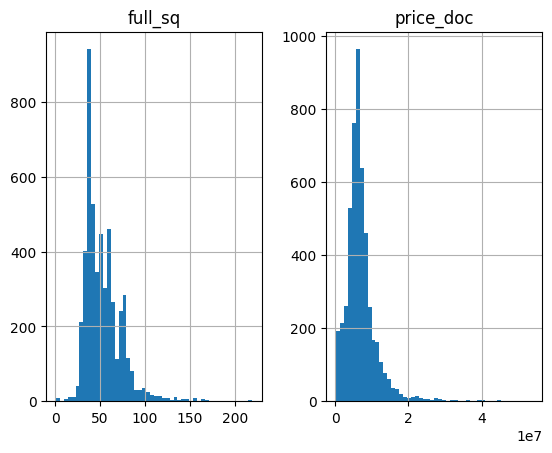

In [20]:
df.hist(bins=50)

In [21]:
df['price_doc'].describe()

,price_doc
count,5.047000e+03
mean,7.056259e+06
std,4.480614e+06
min,3.000000e+05
25%,4.687598e+06
50%,6.250000e+06
75%,8.264563e+06
max,5.378714e+07


In [22]:
df['full_sq'].describe()

,full_sq
count,5048.000000
mean,53.572900
std,20.896383
min,1.000000
25%,38.000000
50%,49.000000
75%,63.000000
max,219.000000


<Axes: xlabel='price_doc'>

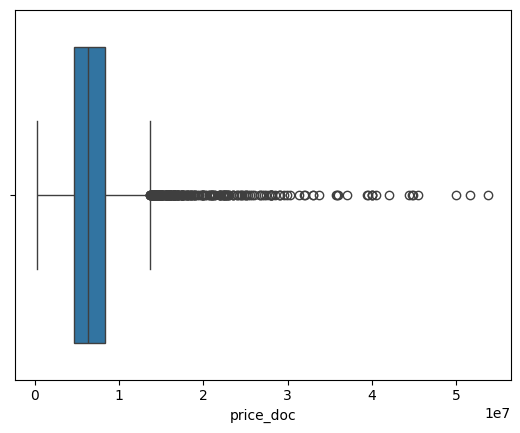

In [23]:
sns.boxplot(x=df['price_doc'])

<Axes: xlabel='full_sq'>

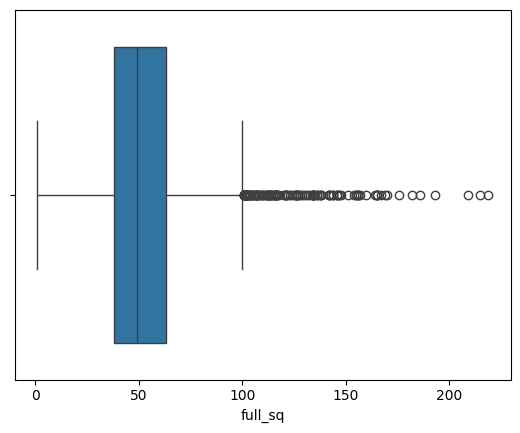

In [24]:
sns.boxplot(x=df['full_sq'])

In [25]:
df = df[
    (df['price_doc'] <= df['price_doc'].quantile(0.95))
    & (df['full_sq'] <= df['full_sq'].quantile(0.95))
]

array([[<Axes: title={'center': 'full_sq'}>,
        <Axes: title={'center': 'price_doc'}>]], dtype=object)

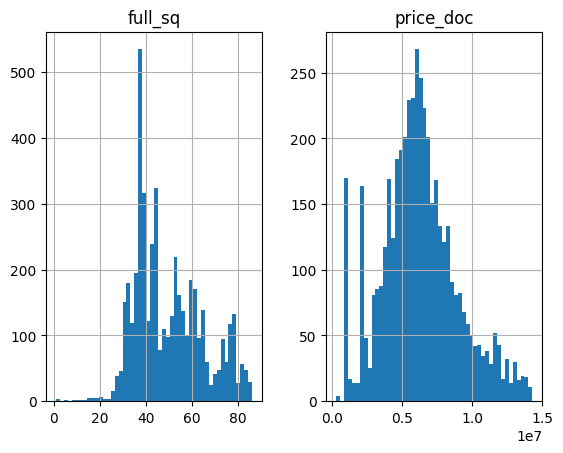

In [26]:
df.hist(bins=50)

In [27]:
df.describe()

,full_sq,price_doc
count,4668.000000,4.668000e+03
mean,49.915596,6.262458e+06
std,14.943539,2.724044e+06
min,1.000000,3.000000e+05
25%,38.000000,4.550000e+06
50%,46.000000,6.051250e+06
75%,60.000000,7.750000e+06
max,86.000000,1.430000e+07


In [28]:
checkStandart(df, 'full_sq')

Statistic: 0.12440248264296977, p-value: 2.003385252551637e-63
Распределение отличается от нормального (отклоняем H0)


In [29]:
checkStandart(df, 'price_doc')

Statistic: 0.056612411744140334, p-value: 1.9107563092295784e-13
Распределение отличается от нормального (отклоняем H0)


In [30]:
from scipy.stats import spearmanr

# Применям ранговую корреляцию Спирмана, так как распределение не нормальное
corr, p_value = spearmanr(df['price_doc'], df['full_sq'])
print(f"Spearman's correlation: {corr}, p-value: {p_value}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print('Корреляция значима (отклоняем H0)')
else:
    print('Корреляция незначима (не отклоняем H0)')

Spearman's correlation: 0.431516972695883, p-value: 4.583669083144677e-211
Корреляция значима (отклоняем H0)


In [31]:
df2 = price_doc_to_class(df) # Добавляем категориальную переменную

In [32]:
# Строим таблицу сопряженности
contingency_table = pd.crosstab(df2['build_type'], df2['class'])
print(contingency_table)

class       cheap  expensive  normal
build_type                          
brezh         263        107    2121
hrush         109         44     775
modern        134        126     800
stal           16         22     151


In [33]:
# Критерий хи-квадрат для проверки статистической гипотезы о независимости этих переменных
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:\n", expected)

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу - существует связь между переменными.")
else:
    print("Не отвергаем нулевую гипотезу - связи между переменными не обнаружено.")

Chi-square statistic: 92.26716804805791
p-value: 1.0239185405985243e-17
Degrees of freedom: 6
Expected frequencies:
 [[ 278.55655527  159.55634105 2052.88710368]
 [ 103.77377892   59.44130249  764.78491859]
 [ 118.53470437   67.89631534  873.56898029]
 [  21.13496144   12.10604113  155.75899743]]
Отвергаем нулевую гипотезу - существует связь между переменными.


## Регрессионный анализ


У нас есть корреляция между full_sq, build_type и price_doc
Так как у нас есть категориальный признак, преобразуем его в несколько числовых с помощью метода one-hot


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [35]:
# Определение признаков и целевой переменной
X = df[['full_sq', 'build_type']]
x = df['full_sq']
y = df['price_doc']

In [36]:
X = pd.get_dummies(df, 'build_type',dtype=int)
X

,full_sq,price_doc,build_type_brezh,build_type_hrush,build_type_modern,build_type_stal
0,43,5533460.0,0,0,1,0
1,66,9900000.0,1,0,0,0
2,55,1990000.0,1,0,0,0
3,45,6500000.0,0,1,0,0
4,43,8500000.0,0,1,0,0
...,...,...,...,...,...,...
5042,19,1100000.0,1,0,0,0
5043,42,7000000.0,0,1,0,0
5044,34,5400000.0,1,0,0,0
5045,50,8000000.0,1,0,0,0


In [37]:
# Разделение данных (например, 80% обучающая, 20% тестовая)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


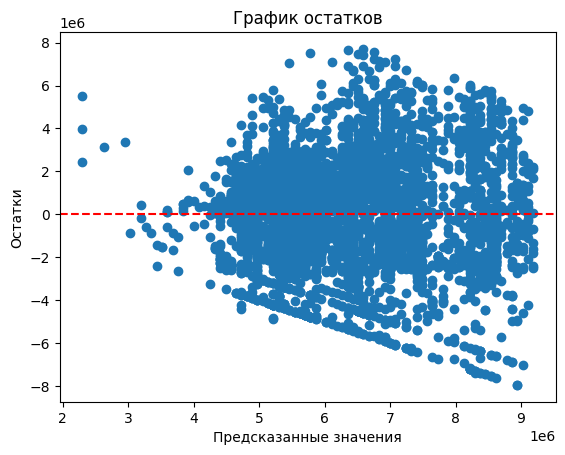

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Добавляем константу для intercept
x = sm.add_constant(x)

# Создаем и обучаем модель OLS
model = sm.OLS(y, x)
results = model.fit()

# Предсказанные значения и остатки
predicted_values = results.fittedvalues
residuals = results.resid

# Строим график остатков
plt.scatter(predicted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

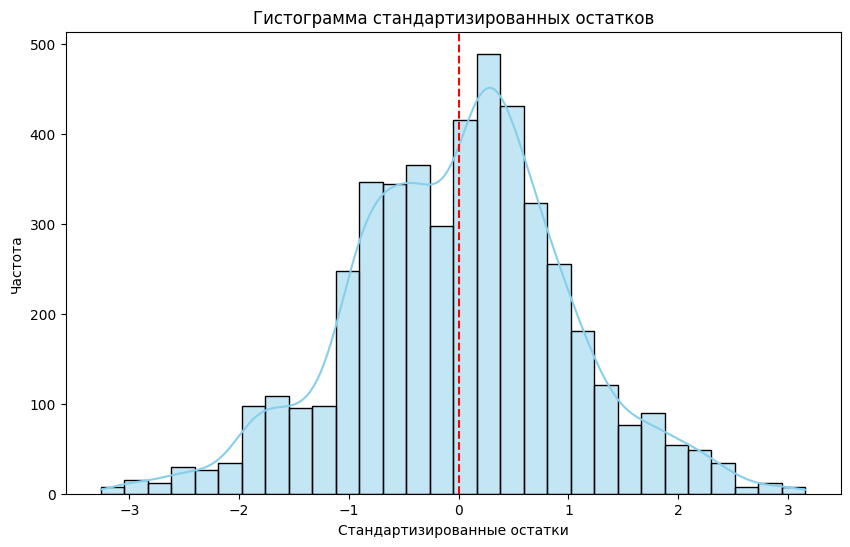

In [39]:
# Гистограмма стандартизированных признаков
# Рассчитываем стандартное отклонение остатков
std_residuals = np.std(residuals)

# Стандартизированные остатки
standardized_residuals = residuals / std_residuals

# Построение гистограммы стандартизированных остатков
plt.figure(figsize=(10, 6))
sns.histplot(standardized_residuals, kde=True, bins=30, color='skyblue')
plt.xlabel('Стандартизированные остатки')
plt.ylabel('Частота')
plt.title('Гистограмма стандартизированных остатков')
plt.axvline(0, color='red', linestyle='--')  # линия на уровне 0
plt.show()

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_doc   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     1149.
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          1.98e-225
Time:                        08:43:07   Log-Likelihood:                -75278.
No. Observations:                4668   AIC:                         1.506e+05
Df Residuals:                    4666   BIC:                         1.506e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.217e+06   1.25e+05     17.802      0.000    1.97e+06    2.46e+06
full_sq     8.104e+04   2390.396     33.903      0.000    7.64e+04    8.57e+04
==============================================================================
Omnibus:                       17.270   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.465
Skew:                          -0.077   Prob(JB):                     3.60e-05
Kurtosis:                       3.285   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

p-значение меньше, чем выбранный уровень значимости, это говорит о том, что коэффициенты являются значимыми

Если p-значение (Prob F-statistic) меньше стандартного уровня значимости, это означает, что хотя бы одна из независимых переменных оказывает статистически значимое влияние на зависимую переменную.
В данном случае p-значение чрезвычайно мало (меньше 0.05), что подтверждает, что модель регрессии в целом является статистически значимой

**Нормальность остатков**:

Omnibus и Jarque-Bera (JB) — это тесты, которые проверяют гипотезу о нормальности распределения остатков.
Omnibus: значение 17.270 с p-значением 0.000.
Jarque-Bera (JB): значение 20.465 с p-значением 3.60e-05.
Оба теста указывают на отклонение остатков от нормального распределения (p < 0.05), что может свидетельствовать о нарушении допущения нормальности остатков.

**Автокорреляция остатков**:

Durbin-Watson (DW) тест используется для проверки автокорреляции остатков. Значение DW равно 1.972, что близко к 2, и это указывает на отсутствие значительной автокорреляции (при 2 автокорреляция отсутствует).

**Гетероскедастичность**:

ниже проведен тест Бреуша-Пагана, который показал, что дисперсия остатков не является постоянной, следовательно, присутсвует гетероскедастичность




In [41]:
intercept, slope = results.params
print(f"Уравнение регрессии: y = {intercept} + {slope} * X")

Уравнение регрессии: y = 2217189.031632653 + 81042.17694110361 * X


In [42]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Функция для вычисления VIF
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data


vif_result = calculate_vif(x)

print(vif_result)


  Variable        VIF
0    const  12.159858
1  full_sq   1.000000


Нет признаков избыточности переменных среди независимых переменных, так как VIF для full_sq находится на приемлемом уровне.


